In [45]:
import pandas as pd
import numpy as np
import scipy as sp

from scipy.stats import skewtest, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.multicomp import MultiComparison

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


import seaborn as sbn
import matplotlib.pyplot as plt

In [2]:
#https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php

The ANOVA test help us to stablish wheter there is a difference among the mean values of several groups. So it tests the null hypothesis that all the mean values are equal. If there are at least two groups with different mean values the test cannot tell us which groups have the different values.

ANOVA return two values: the f-score and the p-value. A big f-score and a low p-value tell us that we should accept the alternative hypothesis against the null hypothesis.

There are three assupmtions when using ANOVA:


    -The dependent variable (y) is normally distributed (skew/skewtest).
    
    -The variances are homogeneus (Levene's test).
    
    - Independence of the observations.
   
ANOVA may work if the normallity of the data is not fullfilled, but it has serius problems when there is not independence in the observations.

ANOVA can only be used for numerical dependent data (y) and numerical or categorical independent data (X).

We can perform an ANOVA test in two ways: with ols or with sp.stats.f_oneway method. Lets see each of them. They give us similarly results but not exactly the same ones.

# ANOVA for dimensionality reduction

We can use the ANOVA test to reduce the number of indpendent variables for our model by reducing the noise in the data

In [3]:
path = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DA0101EN/automobileEDA.csv'
df = pd.read_csv(filepath_or_buffer=path)
df.head()

,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,horsepower-binned,diesel,gas
0,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,...,9.0,111.0,5000.0,21,27,13495.0,11.190476,Medium,0,1
1,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,0.811148,...,9.0,111.0,5000.0,21,27,16500.0,11.190476,Medium,0,1
2,1,122,alfa-romero,std,two,hatchback,rwd,front,94.5,0.822681,...,9.0,154.0,5000.0,19,26,16500.0,12.368421,Medium,0,1
3,2,164,audi,std,four,sedan,fwd,front,99.8,0.848630,...,10.0,102.0,5500.0,24,30,13950.0,9.791667,Medium,0,1
4,2,164,audi,std,four,sedan,4wd,front,99.4,0.848630,...,8.0,115.0,5500.0,18,22,17450.0,13.055556,Medium,0,1


In [4]:
df.columns = df.columns.str.replace("-", "_")

In [5]:
#lets make a simple cleaning of the data
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#we are going to work only with numeric data
df2 = df.drop(labels=df.columns[~(df.dtypes==np.float64)], axis=1)
df2.dtypes

wheel_base           float64
length               float64
width                float64
height               float64
bore                 float64
stroke               float64
compression_ratio    float64
horsepower           float64
peak_rpm             float64
price                float64
city_L/100km         float64
dtype: object

In [6]:
#the dependent variable in this model is the price (y) and the others are the independent (X)
y = df2.price
X = df2.drop("price", axis=1)

In [7]:
df2.corr().sort_values(by="price", ascending=False).price

price                1.000000
city_L/100km         0.803669
horsepower           0.802040
width                0.744176
length               0.689466
wheel_base           0.591956
bore                 0.544375
height               0.182407
stroke               0.107893
compression_ratio    0.067759
peak_rpm            -0.103535
Name: price, dtype: float64

In [8]:
#We can reduce the dimentionality of the model by using sklearn.feature_selection.SelectPercentile
sel = SelectPercentile(score_func=f_regression, percentile=50)
sel.fit(X, y)
X_sel = sel.transform(X)

#the change in dimentionaly
X.shape, X_sel.shape

/home/brayan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


((196, 10), (196, 5))

In [9]:
#lets see the chosen columns:
#as we can see below, only the columns with the higest correlation with the price were chosen
for cols in zip(sel.get_support(), X.columns): print(cols)

(True, 'wheel_base')
(True, 'length')
(True, 'width')
(False, 'height')
(False, 'bore')
(False, 'stroke')
(False, 'compression_ratio')
(True, 'horsepower')
(False, 'peak_rpm')
(True, 'city_L/100km')


/home/brayan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


We use the dimentionaly reduction to obtain a better dataset to improve the performance of the predictions. So, lets test this new results.

We start by spliting the data into two sets: test and train. When we have a dataset to build a model we do not use the whole data to build the model, we need to split it into a training set and a testing set. The training set will be used to build the model and the testing set will be used to test that model, to see how good are its predictions. The training set is around a 75% of the data, or more. 

These are some links to understand better why we split the data into testing and training:

        https://www.youtube.com/watch?v=_vdMKioCXqQ
        https://docs.microsoft.com/en-us/analysis-services/data-mining/training-and-testing-data-sets?view=asallproducts-allversions


In [10]:
#1. Spliting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

#2. Selecting the new data
#2.a Initializing the selector
select = SelectPercentile(score_func=f_regression, percentile=95)

#2.b Selecting the data for the training
select.fit(X_train, y_train)
X_train_sel = select.transform(X_train)

#2.c. And the data selected for the test
X_test_sel = select.transform(X_test)

/home/brayan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [11]:
print(X_train.shape, X_train_sel.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(147, 10) (147, 9) (147,)
(49, 10) (49,)


In [12]:
#3. Testing the selection
lr     = LinearRegression().fit(X_train, y_train)      #all the columns
lr_sel = LinearRegression().fit(X_train_sel, y_train)  #selected colums

#3.b. Comparing the results
print("Score all cols: ", lr.score(X=X_test, y=y_test))
print("Score sel cols: ", lr_sel.score(X=X_test_sel, y=y_test))

Score all cols:  0.8107193547824856
Score sel cols:  0.8259427599472775


In [13]:
#study the dependence of the score with the number/type of columns selected by SelectPercentile

# Model testing with ANOVA

We can use ANOVA to test how good is a model. We build different models using different variables to fit a target variable (y) and see how these variables affect the statistics of the model.

Here we are not doing a ML model since we are not spliting our data to make a training and testing analysis, it is just a descriptive model that give us information about the data.

In [14]:
df.corr().price.sort_values(ascending=False)

price                1.000000
engine_size          0.889265
curb_weight          0.828483
city_L/100km         0.803669
horsepower           0.802040
width                0.744176
length               0.689466
wheel_base           0.591956
bore                 0.544375
height               0.182407
normalized_losses    0.138183
diesel               0.117725
stroke               0.107893
compression_ratio    0.067759
symboling           -0.076420
peak_rpm            -0.103535
gas                 -0.117725
city_mpg            -0.692550
highway_mpg         -0.707466
Name: price, dtype: float64

In [15]:
#lets test the price and the length
anova_pl = ols(formula="price~length", data=df).fit()
print(anova_pl.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     175.8
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           5.53e-29
Time:                        10:55:37   Log-Likelihood:                -1972.8
No. Observations:                 196   AIC:                             3950.
Df Residuals:                     194   BIC:                             3956.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.324e+04   5771.860    -10.956      0.0

In [16]:
#one of the most important values to see in the table above is the R-squared, this one tell us how good is the fit, the closes to 1 it is better.
#we can see the same information from above with more clarity
sm.stats.anova_lm(anova_pl)

,df,sum_sq,mean_sq,F,PR(>F)
length,1.0,5.750026e+09,5.750026e+09,175.779545,5.531750e-29
Residual,194.0,6.346045e+09,3.271157e+07,NaN,NaN


In [17]:
#we can see the p-values for the parameters (PR(>F) above)
anova_pl.pvalues

Intercept    4.700721e-22
length       5.531750e-29
dtype: float64

In [18]:
#lets see the confidence intervals, for this we use wls_prediction_std
#l-> lower, u->upper
_, l, u = wls_prediction_std(anova_pl)

/home/brayan/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/brayan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/brayan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


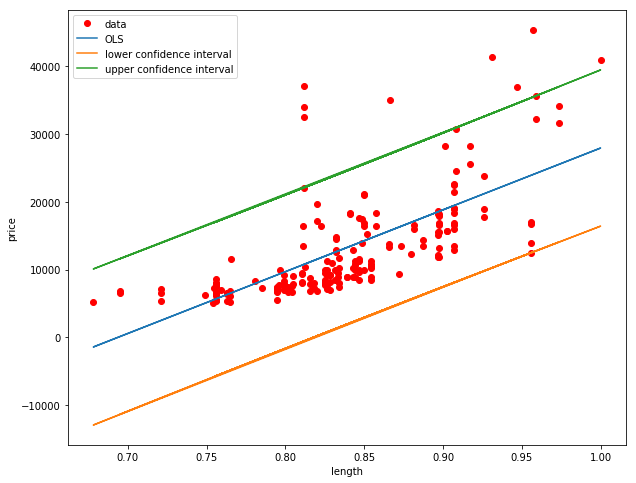

In [19]:
fig = plt.figure(figsize=(10, 8))
plt.plot(df.length, df.price, "ro", label="data")
plt.plot(df.length, anova_pl.fittedvalues, label="OLS")
plt.plot(df.length, l, label="lower confidence interval")
plt.plot(df.length, u, label="upper confidence interval")
plt.xlabel("length")
plt.ylabel("price")
plt.legend()

In [20]:
#lets try another models
#price ~ horsepower
anova_ph = ols(data=df, formula="price~horsepower").fit()
print(anova_ph.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     349.8
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           2.69e-45
Time:                        10:55:38   Log-Likelihood:                -1935.0
No. Observations:                 196   AIC:                             3874.
Df Residuals:                     194   BIC:                             3881.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4879.5060   1018.331     -4.792      0.0

In [21]:
sm.stats.anova_lm(anova_ph)

,df,sum_sq,mean_sq,F,PR(>F)
horsepower,1.0,7.781023e+09,7.781023e+09,349.82655,2.686405e-45
Residual,194.0,4.315048e+09,2.224252e+07,NaN,NaN


In [22]:
df.columns

Index(['symboling', 'normalized_losses', 'make', 'aspiration', 'num_of_doors',
       'body_style', 'drive_wheels', 'engine_location', 'wheel_base', 'length',
       'width', 'height', 'curb_weight', 'engine_type', 'num_of_cylinders',
       'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_ratio',
       'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price',
       'city_L/100km', 'horsepower_binned', 'diesel', 'gas'],
      dtype='object')

In [23]:
#price~enginezise+curbweight
anova_pec = ols(data=df, formula="price~engine_size+curb_weight").fit()
print(anova_pec.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     402.8
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.31e-69
Time:                        10:55:38   Log-Likelihood:                -1875.0
No. Observations:                 196   AIC:                             3756.
Df Residuals:                     193   BIC:                             3766.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.401e+04   1351.937    -10.360      

In [24]:
#as we can see this last model give us a better prediction of the price since it has a bigger R2
#ols allow us to include categorical variables in our model, to do so in the formula parameter we
#just need to add a C before the name of the categorical variable
#we know that the mark is an important variable to predict the price:
anova_pecm = ols(data=df, formula="price~engine_size+curb_weight+C(make)").fit()
print(anova_pecm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     103.1
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           4.09e-88
Time:                        10:55:39   Log-Likelihood:                -1772.1
No. Observations:                 196   AIC:                             3592.
Df Residuals:                     172   BIC:                             3671.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [25]:
#the variables with pvalues<0.05
anova_pecm.pvalues[anova_pecm.pvalues<0.05]

Intercept                   1.291145e-03
C(make)[T.bmw]              4.568483e-06
C(make)[T.isuzu]            3.101789e-02
C(make)[T.mercedes-benz]    5.033619e-05
C(make)[T.mitsubishi]       9.699988e-03
C(make)[T.nissan]           1.536793e-02
C(make)[T.plymouth]         3.046017e-02
C(make)[T.porsche]          1.908563e-10
C(make)[T.renault]          1.328354e-02
C(make)[T.subaru]           2.596772e-02
C(make)[T.toyota]           1.336285e-02
engine_size                 1.098555e-11
curb_weight                 1.434608e-05
dtype: float64

In [26]:
#now, our R2 is around 0.93, much better than the previuos models
#for each unique value in "make" ols will produce a new variable. 
#Although, we do not only look for a good R2, we also want a low "Omnibus" and a low "Cond. No" since those
#represent how are distributed the residuals of the model; a low "Omnibus" represents a more gaussian distribution for those

# ANOVA for testing differences between groups

In [27]:
#We usually use ANOVA when we already have a model to test, when we have already decided which one is our model 
#and we want to test how good the independent variables predic de value of the depend variable. With ANOVA we can see
#which of those variables is actually a good predictor for our model or if this variable keeps any relationship (equal means) with
#another one and so we can elimite it from our model.

In [28]:
#lets see how differ the mean values of the price for some car models and so see if they can allow 
#us to predict the price of the car
volvo_honda = df[["price", "make"]][(df["make"]=="volvo") | (df["make"]=="honda")]
volvo_honda

,price,make
29,6479.0,honda
30,6855.0,honda
31,5399.0,honda
32,6529.0,honda
33,7129.0,honda
34,7295.0,honda
35,7295.0,honda
36,7895.0,honda
37,9095.0,honda
38,8845.0,honda


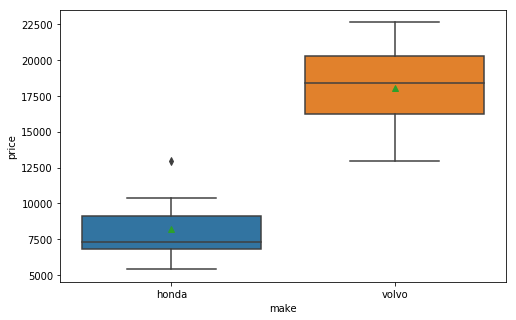

In [29]:
fig,ax = plt.subplots(figsize=(8,5))
sbn.boxplot(data=volvo_honda, x="make", y="price", showmeans=True, ax=ax)

In [30]:
#so, as we can see there is a clear difference between the mean values of the two tipes of cars, but lets
#use ANOVA to test this difference
#for this we use stats.f_oneway from scipy
group_volvoHonda = volvo_honda.groupby(by="make")
group_volvoHonda.get_group(name="honda")
f_val, p_val = sp.stats.f_oneway(group_volvoHonda.get_group(name="honda")["price"], group_volvoHonda.get_group(name="volvo")["price"])
print("ANOVA: f_val = %.4f p_val = %.10f" %(f_val, p_val))

ANOVA: f_val = 79.5134 p_val = 0.0000000093


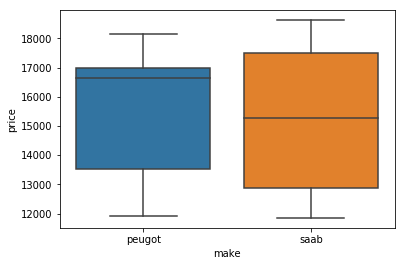

In [31]:
#we got a large f-value and a small p-value, then we can reject the null hypothesis that the means are the same.
#lets test another models: saab and peugot
saab_peugot = df[["make", "price"]][(df["make"]=="saab") | (df["make"]=="peugot")]
sbn.boxplot(data=saab_peugot, x="make", y="price")

In [32]:
saab_peugot = saab_peugot.groupby(by="make")
f_val, p_val = sp.stats.f_oneway(saab_peugot.get_group(name="saab")["price"], saab_peugot.get_group(name="peugot")["price"])
print("ANOVA: f_val = %.4f p_val = %.10f" %(f_val, p_val))

ANOVA: f_val = 0.0450 p_val = 0.8348594642


In [33]:
#here we see a small f-value and a large p-value meaning that the mean values of both groups
#are similarly each other and so we can not reject the null hypothesis

In [34]:
#or we can even test for several model at the same time
make_group = df[["price", "make"]].groupby(by="make")
make_group.groups.keys()

dict_keys(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda', 'isuzu', 'jaguar', 'mazda', 'mercedes-benz', 'mercury', 'mitsubishi', 'nissan', 'peugot', 'plymouth', 'porsche', 'renault', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo'])

In [35]:
f_val, p_val = sp.stats.f_oneway(make_group.get_group("alfa-romero")["price"],
                                 make_group.get_group("audi")["price"],
                                 make_group.get_group("bmw")["price"],
                                 make_group.get_group("chevrolet")["price"],
                                 make_group.get_group("dodge")["price"],
                                 make_group.get_group("honda")["price"],
                                 make_group.get_group("isuzu")["price"],
                                 make_group.get_group("jaguar")["price"],
                                 make_group.get_group("mazda")["price"],
                                 make_group.get_group("mercedes-benz")["price"],
                                 make_group.get_group("mercury")["price"],
                                 make_group.get_group("mitsubishi")["price"],
                                 make_group.get_group("nissan")["price"],
                                 make_group.get_group("peugot")["price"],
                                 make_group.get_group("plymouth")["price"],
                                 make_group.get_group("porsche")["price"],
                                 make_group.get_group("renault")["price"],
                                 make_group.get_group("saab")["price"],
                                 make_group.get_group("subaru")["price"],
                                 make_group.get_group("toyota")["price"],
                                 make_group.get_group("volkswagen")["price"],
                                 make_group.get_group("volvo")["price"])
print("ANOVA: f_val = ",f_val, "p_val =", p_val)

ANOVA: f_val =  31.278119352355812 p_val = 3.8352790812292106e-48


In [44]:
#lets do this same calculation but using ols:
anova_pm_ols = ols(data=df, formula="price~C(make)").fit()
print(anova_pm_ols.summary())
sm.stats.anova_lm(anova_pm_ols)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     31.28
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           3.84e-48
Time:                        11:04:37   Log-Likelihood:                -1882.8
No. Observations:                 196   AIC:                             3810.
Df Residuals:                     174   BIC:                             3882.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

,df,sum_sq,mean_sq,F,PR(>F)
C(make),21.0,9.562833e+09,4.553730e+08,31.278119,3.835279e-48
Residual,174.0,2.533237e+09,1.455884e+07,NaN,NaN


In [36]:
#and as we can see, both methods (ols and scipy f_oneway) give us the same result and
#we can say that the model (make) of the car is a good predictor for the price
#although in this example as we know there are car models that have mean values that are almost the same (under a ANOVA test)
#so, if we want to see which ones have this issue we can to permorm a Test Post-hoc. 

# Test Post-hoc

In [50]:
comparisson = MultiComparison(df.price, df.make)
comparisson = comparisson.tukeyhsd()
print(comparisson)

          Multiple Comparison of Means - Tukey HSD,FWER=0.05          
    group1        group2      meandiff     lower       upper    reject
----------------------------------------------------------------------
 alfa-romero       audi      2360.8333   -7489.1937  12210.8603 False 
 alfa-romero       bmw       10620.4167  1189.7338   20051.0995  True 
 alfa-romero    chevrolet    -9491.3333 -20865.1648  1882.4982  False 
 alfa-romero      dodge      -7622.8889 -16909.5834  1663.8056  False 
 alfa-romero      honda      -7313.641  -16236.0085  1608.7265  False 
 alfa-romero      isuzu      -6581.8333 -19298.1635  6134.4969  False 
 alfa-romero      jaguar     18401.6667  5685.3365   31117.9969  True 
 alfa-romero      mazda      -5573.7949 -14496.1624  3348.5726  False 
 alfa-romero  mercedes-benz  18148.6667  8717.9838   27579.3495  True 
 alfa-romero     mercury     1004.6667  -15080.3601  17089.6934 False 
 alfa-romero    mitsubishi   -6258.5641 -15180.9316  2663.8034  False 
 alfa-

In [51]:
#reject tell us if we can or not reject the null hypothesis. For instance for honda and volvo we know that we can reject the nh
#but for pegout and saab we cannot reject it.